In [121]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
 
import seaborn as sns
 
import numpy as np
 
import matplotlib.pyplot as plt
 
from sklearn.neighbors import NearestNeighbors
 
from scipy.sparse import csr_matrix
 
from surprise import Reader, Dataset
 
from surprise.model_selection import train_test_split
 
from surprise import SVDpp, accuracy
 
from surprise.model_selection import cross_validate
 
from collections import defaultdict
 
from surprise import SVD, SVDpp, NMF
 
from surprise import SlopeOne, CoClustering

import matplotlib

In [64]:
df_all = pd.read_csv("/Users/shulundong/Downloads/archive/ratings.csv")

In [65]:
df_all.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [66]:
df_all.shape

(100004, 4)

In [67]:
df_all.nunique()

userId         671
movieId       9066
rating          10
timestamp    78141
dtype: int64

In [69]:
Sparsity = 1-100004/(671*9066)
Sparsity

0.9835608583913366

In [70]:
# Check movie's number of ratings
df_all.groupby("movieId")['rating'].count().sort_values(ascending=False).head()

movieId
356    341
296    324
318    311
593    304
260    291
Name: rating, dtype: int64

In [71]:
df_all.groupby("movieId")['rating'].count().sort_values(ascending=True).head()

movieId
163949    1
26485     1
26480     1
26471     1
26467     1
Name: rating, dtype: int64

In [ ]:
# Check user's number of rating

In [78]:
df_all.groupby("userId")['rating'].count().sort_values(ascending=False).head()

userId
547    2391
564    1868
624    1735
15     1700
73     1610
Name: rating, dtype: int64

In [79]:
df_all.groupby("userId")['rating'].count().sort_values(ascending=True).head()

userId
1      20
498    20
448    20
445    20
444    20
Name: rating, dtype: int64

In [2]:
df = pd.read_csv("/Users/shulundong/Desktop/ML Final Project/final_movie_dataset_wstoryline.csv")

In [3]:
df.head()

,Unnamed: 0,userId,movieId,rating,timestamp,title,genres,tag,imdbId,tmdbId,storyline
0,0,83090,78,2.0,2002-08-19 21:37:12,"Crossing Guard, The (1995)",Action|Crime|Drama|Thriller,"['Nudity (Topless)', 'Jack Nicholson', 'Sean P...",112744,27526.0,"After his daughter died in a hit and run, Fred..."
1,1,114990,1198,5.0,2011-08-21 14:57:11,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,"['adventure', 'archaeology', 'atmospheric', 'H...",82971,85.0,The year is 1936. An archeology professor name...
2,2,34191,161,4.0,2014-07-05 22:40:46,Crimson Tide (1995),Drama|Thriller|War,"['Gene Hackman', 'Viggo Mortensen', 'tom clanc...",112740,8963.0,When some Russian rebels take control of some ...
3,3,50021,1407,3.5,2006-10-17 09:21:05,Scream (1996),Comedy|Horror|Mystery|Thriller,"['suspense', 'teen', 'serial killer', 'slasher...",117571,4232.0,"A year after her mother's death, Sidney Presco..."
4,4,63574,3507,3.0,2000-09-05 16:20:29,"Odd Couple, The (1968)",Comedy,"[""adapted from B'way"", 'starring:Jack Lemmon&W...",63374,11356.0,Felix's (Jack Lemmon) wife has left him and he...


In [11]:
df.groupby("movieId")['rating'].count().sort_values(ascending=False).head()

movieId
527     11
480     11
50      10
593     10
1580     9
Name: rating, dtype: int64

In [51]:
df_agg = df[['userId', 'movieId']].groupby(['movieId']).agg(['count']).sort_values(('userId','count'), ascending=False)

In [52]:
df_agg

,userId
,count
movieId,
527,11
480,11
50,10
593,10
1580,9
...,...
2558,1
2561,1


In [4]:
df_collab = df[['userId', 'movieId', 'rating', 'timestamp']]

We will exclude rarely rated movies to make our recommendation engine more relevant；
To make recommender more relevant, we will also exclude users that did not rate at least 200 movies.

#### Create a utility matrix

In [80]:
utilitymtx = df_all.pivot_table(values='rating', index='userId', columns='movieId', fill_value=0)

In [113]:
utilitymtx

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


## SVD
Applying data dimension reduction methods, specifically SVD, is one of the popular solutions for the sparsity problems. SVD is a matrix factorization algorithm that can extract characteristics of the dataset’s features by splitting the original user-item ratings matrix into three smaller matrix multiplications. Given a 𝑚𝑥 matrix A (N is the number of items, M is the number of users) with rank(𝐴) = r

https://www.alpha-quantum.com/blog/collaborative-filtering-recommender-systems/collaborative-filtering-recommender-system-with-python-from-scratch-using-svd-item-based-model-based-approaches/


In [82]:
SVD = TruncatedSVD(n_components=12, random_state=17)
resultant_matrix = SVD.fit_transform(utilitymtx)
resultant_matrix.shape

(671, 12)

In [83]:
resultant_matrix

array([[ 1.07914743e+00,  9.52010569e-01,  3.06132420e-01, ...,
         1.68394895e-01,  4.25725636e-01,  5.77706832e-01],
       [ 9.47543720e+00,  1.58795163e+00, -1.35576338e+01, ...,
        -1.31492488e+00, -3.68917831e-01,  9.85271177e-01],
       [ 7.81091998e+00, -3.23297075e+00, -2.29537308e+00, ...,
        -3.99929558e-01, -2.01415533e+00,  9.08696077e-01],
       ...,
       [ 3.62297938e+00,  3.85889961e-01,  7.96649539e-03, ...,
         2.95660625e-01, -1.40783247e+00, -1.10080853e+00],
       [ 6.58375511e+00, -2.74549235e-01, -3.07778061e+00, ...,
        -6.76961708e-01, -1.48873663e+00, -1.98765362e+00],
       [ 2.08411106e+01, -4.67025108e+00, -6.63159826e-01, ...,
         7.47804267e-01, -6.22442740e+00, -3.74035138e+00]])

If there is little data available model-based CF model will predict poorly since it will be more difficult to learn the latent features.

### SVD Matrix Factorization User Movie interactions

However, only captures the relationship between the user and the item . In the real world, the observed rating may be affected by the preference of the user or the characteristics of the item.

In [84]:
#find the max and min rating score
max_rate = max(df_all['rating'].values)
min_rate = min(df_all['rating'].values)

In [85]:
max_rate, min_rate

(5.0, 0.5)

In [86]:
reader = Reader(rating_scale=(min_rate,max_rate))
 
data = Dataset.load_from_df(df_all[['userId', 'movieId', 'rating']], reader)

In [87]:
df_all[['userId', 'movieId', 'rating']]

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0
...,...,...,...
99999,671,6268,2.5
100000,671,6269,4.0
100001,671,6365,4.0
100002,671,6385,2.5


### SVD Matrix Factorization with implicit feedback from user ( user rated movies )

SVD++ approach improves on Matrix-factorization approach by including not only explicit ratings, but also implicit ones (e.g. purchases, likes, etc.). Another difference is that SVD++ adds user and item bias terms to the term for MF

In [122]:
trainset = data.build_full_trainset()

In [88]:
algo = SVDpp()
 
algo.fit(trainset);

In [126]:
user_id = trainset.to_raw_uid(1)
 
movie_id = trainset.to_raw_iid(1029)
 
prediction = algo.predict(uid=user_id, iid=movie_id)

In [127]:
prediction

Prediction(uid=2, iid=3390, r_ui=None, est=3.2100602406611602, details={'was_impossible': False})

In [129]:
user_id = trainset.to_raw_uid(10)
 
movie_id = trainset.to_raw_iid(1029)
 
prediction2 = algo.predict(uid=user_id, iid=movie_id)

In [180]:
prediction2

Prediction(uid=11, iid=3390, r_ui=None, est=3.6154558130105166, details={'was_impossible': False})

In [181]:
test_movie_id = [1029, 1061, 1129]

In [184]:
test_movie_id_raw = [trainset.to_raw_iid(x) for x in test_movie_id]

In [186]:
prediction3 = [algo.predict(uid=user_id, iid=x) for x in test_movie_id_raw] 

In [190]:
prediction3[1].est

4.047730946432545

In [191]:
# Make recommendation for all users

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """


    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [134]:
testset = trainset.build_anti_testset()

In [194]:
len(testset)

5983282

In [135]:
predictionls = algo.test(testset)

In [136]:
top_n = get_top_n(predictionls, n=10)

In [137]:
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

1 [318, 2542, 534, 3462, 905, 1217, 8132, 2019, 7502, 741]
2 [318, 905, 926, 3462, 969, 1217, 1172, 1945, 2064, 7502]
3 [2542, 4011, 116797, 1259, 3462, 56782, 922, 1172, 741, 2467]
4 [50, 527, 318, 778, 2318, 2858, 58559, 1221, 2692, 745]
5 [2542, 741, 969, 899, 1217, 1233, 1172, 3462, 1237, 318]
6 [905, 923, 7502, 2064, 1203, 318, 4993, 1228, 50, 134130]
7 [50, 593, 608, 858, 7502, 926, 296, 4993, 3462, 78499]
8 [1221, 8132, 7502, 898, 1299, 905, 3462, 2019, 1213, 1203]
9 [3462, 969, 926, 905, 7502, 858, 1217, 8132, 1203, 7153]
10 [608, 7502, 926, 2318, 2858, 4993, 858, 969, 905, 232]
11 [7153, 7502, 4993, 858, 318, 1221, 5952, 905, 527, 58559]
12 [5952, 1233, 2542, 4993, 50, 7153, 899, 1227, 79702, 1237]
13 [7153, 858, 905, 2542, 1221, 5952, 3462, 260, 2467, 8132]
14 [3462, 969, 318, 527, 7502, 926, 2571, 86882, 858, 2690]
15 [1305, 3037, 7502, 4444, 940, 2971, 3310, 1242, 3424, 5782]
16 [2542, 8132, 1221, 2571, 497, 2690, 905, 7502, 1066, 1957]
17 [534, 1203, 30749, 3030, 2395, 120

In [139]:
accuracy.rmse(predictionls)

RMSE: 0.5113


0.5113432948020294

The drawback of memory-based CF is that it doesn’t scale to real-world scenarios and doesn’t address the well-known cold-start problem, that is when a new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don’t have any ratings enter the system.

Memory-Based Collaborative Filtering approaches can be divided into two main sections: user-item filtering and item-item filtering. A user-item filtering takes a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations.
Item-Item Collaborative Filtering: “Users who liked this item also liked …”
User-Item Collaborative Filtering: “Users who are similar to you also liked 

The key difference of memory-based approach from the model-based techniques (hang on, will be discussed in next paragraph) is that we are not learning any parameter using gradient descent (or any other optimization algorithm). The closest user or items are calculated only by using Cosine similarity or Pearson correlation coefficients, which are only based on arithmetic operations. 

### Neural Network Collaborative Filtering

https://medium.com/deep-recommender-system/a-deep-recommender-system-e2b765d27350

The difficulty of using side features, that may affect the recommendation like the U/PG rating of a movie or the country of the user. We can only use the item ID and the user ID in the case of matrix factorization. It also prevents us from querying an item or user not present in the training set.
The matrix factorization also had the cold start problem due to the fact that it had no feature vector or embedding for the new items
Matrix factorization often tends to recommend popular items to everyone which does not always reflect the specific user interests mostly when Dot products are used.
Matrix factorization works on the simple inner product of the User and item feature embeddings, it is often not enough to capture and represent the complex relations in the user and items.


#### User / Movie Embedding
User Embeddings
Before we dive into the architecture of the model, let’s familiarize ourselves with the concept of embeddings. An embedding is a low-dimensional space that captures the relationship of vectors from a higher dimensional space. 

We can use an arbitrary number of dimensions to represent our users. A larger number of dimensions would allow us to capture the traits of each user more accurately, at the cost of model complexity.

Similarly, we will use a separate item embedding layer to represent the traits of the items (i.e. movies) in a lower dimensional space.

How can we learn the weights of the embedding layer, such that it provides an accurate representation of users and items? -- Collaborative Filtering

The user input vector and item input vector are fed to the user embedding and item embedding respectively, which results in a smaller, denser user and item vectors.

The embedded user and item vectors are concatenated before passing through a series of fully connected layers, which maps the concatenated embeddings into a prediction vector as output. 

##### Model Collaborative Filtering for user movie interaction

NCF is an example of multimodal deep learning as it contains data from 2 pathways namely user and item. The most intuitive way to combine them is by concatenation. But a simple vector concatenation does not account for user-item interactions and is insufficient to model the collaborative filtering effect. To address this NCF adds hidden layers on top of concatenated user-item vectors(MLP framework), to learn user-item interactions. This endows the model with a lot of flexibility and non-linearity to learn the user-item interactions. 

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ast 
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD

import warnings; warnings.simplefilter('ignore')

In [143]:
df_credit = pd.read_csv("/Users/shulundong/Downloads/archive/credits.csv")

In [144]:
df_credit.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [145]:
df_credit.shape

(45476, 3)

In [146]:
df_meta = pd.read_csv("/Users/shulundong/Downloads/archive/movies_metadata.csv")

In [147]:
df_meta.shape

(45466, 24)

In [148]:
df_meta.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [149]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

#### IMDB Weighted Rating

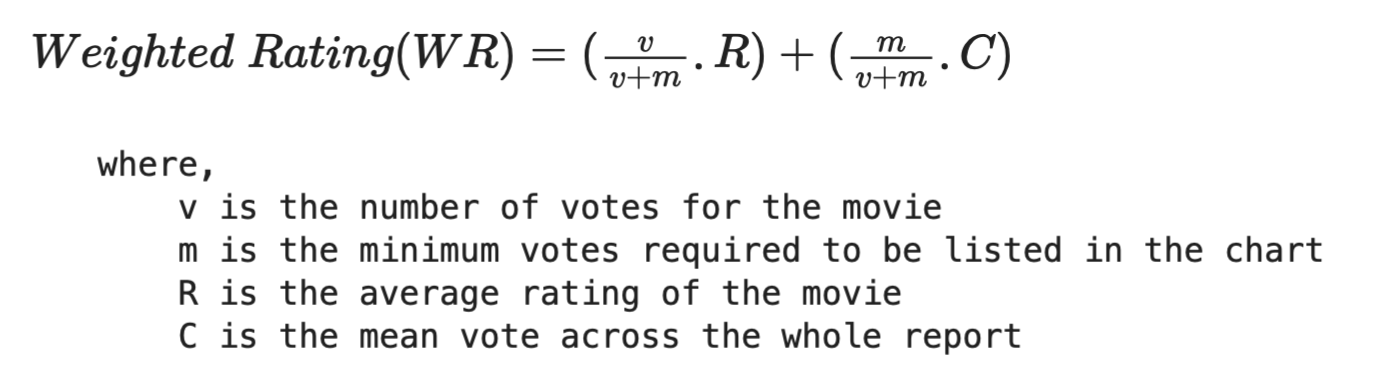

In [153]:
# Find movie with votes
vote_cnt = df_meta[df_meta['vote_count'].notnull()]['vote_count']

In [154]:
# Find movie with vote average
vote_avg = df_meta[df_meta['vote_average'].notnull()]['vote_average']

In [156]:
C = np.mean(vote_avg)
C

5.618207215133889

In [ ]:
# Determine the minmum value required to be listed in the chart

In [158]:
m = vote_cnt.quantile(0.90)
m

160.0

In [167]:
qualified = df_meta[(df_meta['vote_count'] >= m) & 
               (df_meta['vote_count'].notnull()) & 
               (df_meta['vote_average'].notnull())][['title', 
                                                'release_date', 
                                                'vote_count', 
                                                'vote_average', 
                                                'popularity']]

qualified.shape

(4555, 5)

In [168]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [169]:
qualified['weighted_rating'] = qualified.apply(weighted_rating, axis=1)

In [170]:
qualified.sort_values('weighted_rating', ascending=False).head()

,title,release_date,vote_count,vote_average,popularity,weighted_rating
314,The Shawshank Redemption,1994-09-23,8358.0,8.5,51.645403,8.445869
834,The Godfather,1972-03-14,6024.0,8.5,41.109264,8.425439
10309,Dilwale Dulhania Le Jayenge,1995-10-20,661.0,9.1,34.457024,8.421453
12481,The Dark Knight,2008-07-16,12269.0,8.3,123.167259,8.265477
2843,Fight Club,1999-10-15,9678.0,8.3,63.869599,8.256385


In [173]:
data100k = df_all[df_all['movieId'].notnull()]['movieId'].astype('int')

In [174]:
data100k.shape

(100004,)

In [175]:
small_meta = df_meta[df_meta['id'].isin(data100k)]
small_meta.shape

(0, 24)

### Content Based Recommendation System

In [179]:
# Define similarity function and 
from numpy import dot
from numpy.linalg import norm

def cosine_sim(list1, list2):
    result = dot(List1, List2)/(norm(List1)*norm(List2))
    return result

In [ ]:
# create a matrix including pairwise similarity for movies

def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

### Content Based + Movie Info + Popularity and Rating

In [ ]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [ ]:
similarity_ls = cosine_sim(tfidf_mat, tfidf_mat)

In [ ]:
def improved_recommendations(title):
    idx = indices[title]
    #Find the cosine similarity score for this movie and 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:10]
    
    #Find the similar movies index
    movie_indices = [i[0] for i in sim_scores]
    #Get movies' info including voting
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    
    #Create a qualified list with weighted rating
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & 
                       (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

### Hybrid Recommendation System: Content Based + Collaborative Filtering (SVD++)

Combining collaborative filtering with improved content based

In [ ]:
def hybrid_recommendation(title, user_id):
    #Get the recommendation movie list from the content based recommendation system
    idx = indices[title]
    #Find the cosine similarity score for this movie and 
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:20]
    
    #Find the similar movies index
    movie_indices = [i[0] for i in sim_scores]
    #Get movies' info including voting
    movies = smd.iloc[movie_indices][['id', 'title', 'vote_count', 'vote_average', 'year']]
    
    raw_user_id = trainset.to_raw_uid(user_id)
    
    raw_movie_id = [trainset.to_raw_iid(x) for x in movies['id']]
 
    movies['est_rate'] = [algo.predict(uid=user_id, iid=x) for x in raw_movie_id] 
    
    movies = movies.sort_values('est_rate', ascending=False).head(10)
    
    return movies